# 12 Doubly Robust Estimation

- 이전에 우리는 ATE를 추정하는 방법(confounder를 control)으로 regression을 이용하던가 ps score를 이용하는 방법을 배웠다.
- Doubly Robust Estimation
    - ps score랑 regression을 같이 사용하는 것
    - 그래서 둘 중 하나가 틀려도 ATE를 roubst하게 잘 구할 수 있다.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

In [2]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state=5)

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


- 이전 챕터에서 봤듯이 `success_expect`가 높을수록 세미나에 참여하는 경향이 있다.
- 따라서 이런 confounder를 ps score나 regression으로 control할 수 있다.

In [4]:
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False) # categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


## Doubly Robust Estimation

- 먼저 estimator는 아래와 같다.
  - 앞부분은 $E[Y_1]$ 추정하고 뒷부분은 $E[Y_0]$을 추정한 것이다.
$$\hat{ATE} = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg) - \frac{1}{N}\sum \bigg( \dfrac{(1-T_i)(Y_i - \hat{\mu_0}(X_i))}{1-\hat{P}(X_i)} + \hat{\mu_0}(X_i) \bigg)$$

- $\hat{P}(x)$: estimation of the propensity score
- $\hat{\mu_1}(x)$: estimation of $E[Y|X,T=1]$
- $\hat{\mu_0}(x)$: estimation of $E[Y|X,T=0]$

In [14]:
def doubly_robust(df, X, T, Y):
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [15]:
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

doubly_robust(data_with_categ, X, T, Y)

0.38822148808178253

In [16]:
from joblib import Parallel, delayed # for parallel processing

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(doubly_robust)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

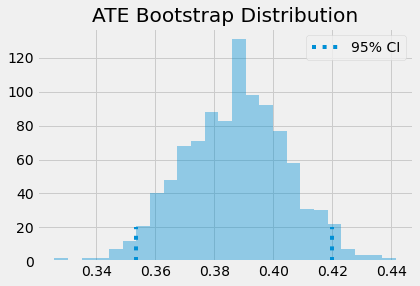

In [17]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 20, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 20, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();

- 위의 estimator가 의미하는 바를 이제 알아보자.
- ps score와 linear regression 두 가지를 사용함으로서 서로를 보완하는 역할을 한다.
- 둘 중 하나만 올바르게 구하면 ATE를 잘 추정할 수 있다.
- 일단 $E[Y_1]$만 살펴보자. $E[Y_0]$는 동일하게 적용하면 된다.

- 먼저 ps score $\hat{P}(x)$이 틀리고 regression으로 구한 $\hat{\mu}(x)$는 잘 구했다고 가정하자.
- 아래 식에서 그러면 $Y_i - \hat{\mu_1}(X_i)$가 0이 되기에 ps score는 무시되고 $\hat{\mu_1}(X_i)$만 남는다.

$$\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_i(Y_i - \hat{\mu_1}(X_i))}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)$$

- 실제 데이터로 확인해보자

In [10]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_ps(df, X, T, Y):
    # wrong PS model
    np.random.seed(654)
    ps = np.random.uniform(0.1, 0.9, df.shape[0])
    mu0 = LinearRegression().fit(df.query(f"{T}==0")[X], df.query(f"{T}==0")[Y]).predict(df[X])
    mu1 = LinearRegression().fit(df.query(f"{T}==1")[X], df.query(f"{T}==1")[Y]).predict(df[X])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [11]:
doubly_robust_wrong_ps(data_with_categ, X, T, Y)

0.37979226165436264

- 맨 처음 우리가 구한 ATE와 약간 다르지만 거의 비슷하다.

- 반대로 ps score $\hat{P}(x)$를 잘 구하고 regression으로 구한 $\hat{\mu}(x)$는 잘못 구했다고 가정하자.
- $\hat{E}[Y_1]$의 식을 rearrange해보자.

$$\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)$$

$$\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \dfrac{T_i\hat{\mu_1}(X_i)}{\hat{P}(X_i)} + \hat{\mu_1}(X_i) \bigg)$$

$$\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i}{\hat{P}(X_i)} - 1\bigg) \hat{\mu_1}(X_i) \bigg)$$

$$\hat{E}[Y_1] = \frac{1}{N}\sum \bigg( \dfrac{T_iY_i}{\hat{P}(X_i)} - \bigg(\dfrac{T_i - \hat{P}(X_i)}{\hat{P}(X_i)}\bigg) \hat{\mu_1}(X_i) \bigg)$$

- 위 식에서 $T_i - \hat{P}(X_i)$가 0이 되면서 잘못구한 $\hat{\mu_1}(X_i)$가 사라지고 ps score로 weighting한 ATE를 구할 수 있다.
- 이것도 실제로 데이터 확인해보자.

In [12]:
from sklearn.linear_model import LogisticRegression, LinearRegression

def doubly_robust_wrong_model(df, X, T, Y):
    np.random.seed(654)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    # wrong mu(x) model
    mu0 = np.random.normal(0, 1, df.shape[0])
    mu1 = np.random.normal(0, 1, df.shape[0])
    return (
        np.mean(df[T]*(df[Y] - mu1)/ps + mu1) -
        np.mean((1-df[T])*(df[Y] - mu0)/(1-ps) + mu0)
    )

In [13]:
doubly_robust_wrong_model(data_with_categ, X, T, Y)

0.39813425907006667

- 둘 다 틀린 경우에 대한 정확한 해답은 아직까지 없다고 한다.